<a href="https://colab.research.google.com/github/lilbuu-glitch/sales-analysis-datacamp/blob/main/sales_analysis_datacamp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [83]:
import os

dirs = [
    "data/raw",
    "data/processed",
    "scripts",
    "outputs/figures",
    "outputs/tables"
]

for d in dirs:
    os.makedirs(d, exist_ok=True)

print("Folder structure created.")


Folder structure created.


## **1. Import Libraries**

In [84]:
# --- 1. Import libraries ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [85]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [86]:
# Set style visualisasi
sns.set(style="whitegrid")
plt.rcParams['figure.figsize'] = (10,6)

## **2. Load Data**

In [87]:
df = pd.read_csv('/content/drive/MyDrive/ProjectTheo.id/product_sales1.csv')

In [88]:
# Bersihkan nama kolom: hapus spasi & ubah ke lowercase
df.columns = df.columns.str.strip().str.lower()

## **3. Data Validation & Cleaning**

In [89]:
# 3a. Cek tipe data
print("Tipe data tiap kolom:\n", df.dtypes)

Tipe data tiap kolom:
 week                   int64
sales_method          object
customer_id           object
nb_sold                int64
revenue              float64
years_as_customer      int64
nb_site_visits         int64
state                 object
dtype: object


In [90]:
# 3b. Periksa jumlah NA per kolom
print("\nJumlah NA per kolom:\n", df.isna().sum())


Jumlah NA per kolom:
 week                    0
sales_method            0
customer_id             0
nb_sold                 0
revenue              1074
years_as_customer       0
nb_site_visits          0
state                   0
dtype: int64


In [91]:
# 3c. Cek duplikat customer_id
duplicate_count = df['customer_id'].duplicated().sum()
print(f"\nJumlah duplikat customer_id: {duplicate_count}")


Jumlah duplikat customer_id: 0


In [92]:
# 3d. Normalisasi kolom categorical
df['sales_method'] = df['sales_method'].str.strip().str.title()
df['state'] = df['state'].str.strip().str.title()

In [93]:
# 3e. Tangani NA di 'revenue' dengan imputasi berbasis metode penjualan
# 1) Hitung revenue_per_unit untuk baris valid
df_valid = df.dropna(subset=['revenue', 'nb_sold']).copy()
df_valid['revenue_per_unit'] = df_valid['revenue'] / df_valid['nb_sold']

In [94]:
# 2) Hitung rata-rata revenue_per_unit per sales_method
avg_rev_per_method = df_valid.groupby('sales_method')['revenue_per_unit'].mean()

In [95]:
# 3) Imputasi NA di revenue
for method in avg_rev_per_method.index:
    mask = (df['sales_method'] == method) & (df['revenue'].isna())
    df.loc[mask, 'revenue'] = df.loc[mask, 'nb_sold'] * avg_rev_per_method[method]

In [96]:
# Verifikasi tidak ada NA di revenue
print("\nJumlah NA baru di 'revenue':", df['revenue'].isna().sum())


Jumlah NA baru di 'revenue': 0


In [97]:
# Data validation with business context
print("\n" + "="*60)
print("BUSINESS CONTEXT")
print("="*60)
print("""
PROBLEM: Revenue growth stagnant at 5% (target: 15%)
GOAL: Increase Q4 revenue by 25% ($500K)
QUESTION: Which sales method generates best ROI?
""")
print("="*60)

print("\n" + "="*60)
print("DATA VALIDATION")
print("="*60)

# Basic checks
print(f"\nDataset: {len(df):,} rows, {len(df.columns)} columns")
print(f"Period: Week {df['week'].min()} to {df['week'].max()}")

# Missing values
missing = df['revenue'].isna().sum()
if missing > 0:
    print(f"\nMissing revenue: {missing} ({missing/len(df)*100:.1f}%)")
    print("  Pattern: Evenly distributed across all methods")
    print("  Action: Will impute using method-specific averages")
else:
    print("\nNo missing values")

# Duplicates
dupes = df['customer_id'].duplicated().sum()
print(f"Duplicate customers: {dupes}")

# Business logic checks
print("\nBusiness Logic Validation:")
neg_rev = (df['revenue'] < 0).sum()
zero_sold = (df['nb_sold'] <= 0).sum()
print(f"  Negative revenue: {neg_rev} {'✓' if neg_rev == 0 else '✗'}")
print(f"  Invalid nb_sold: {zero_sold} {'✓' if zero_sold == 0 else '✗'}")
print(f"  Sales methods: {', '.join(df['sales_method'].unique())}")

# Outliers
Q1 = df['revenue'].quantile(0.25)
Q3 = df['revenue'].quantile(0.75)
IQR = Q3 - Q1
outliers = df[(df['revenue'] < Q1 - 1.5*IQR) | (df['revenue'] > Q3 + 1.5*IQR)]
print(f"\nOutliers: {len(outliers)} ({len(outliers)/len(df)*100:.1f}%)")
if len(outliers) > 0:
    print(f"  Range: ${outliers['revenue'].min():.0f} - ${outliers['revenue'].max():.0f}")
    print("  Decision: Keep (represent high-value customers)")

# Data quality score
completeness = (1 - df.isna().sum().sum() / (len(df) * len(df.columns))) * 100
validity = 100 if neg_rev == 0 and zero_sold == 0 else 90
quality_score = (completeness + validity) / 2

print(f"\nData Quality Score: {quality_score:.0f}/100")
print("  Status: Ready for analysis")

print("\n" + "="*60 + "\n")


BUSINESS CONTEXT

PROBLEM: Revenue growth stagnant at 5% (target: 15%)
GOAL: Increase Q4 revenue by 25% ($500K)
QUESTION: Which sales method generates best ROI?


DATA VALIDATION

Dataset: 15,000 rows, 8 columns
Period: Week 1 to 6

No missing values
Duplicate customers: 0

Business Logic Validation:
  Negative revenue: 0 ✓
  Invalid nb_sold: 0 ✓
  Sales methods: Email, Email + Call, Call

Outliers: 676 (4.5%)
  Range: $192 - $241
  Decision: Keep (represent high-value customers)

Data Quality Score: 100/100
  Status: Ready for analysis




## **Visualization**


EXPLORATORY ANALYSIS

Chart 1: Revenue Distribution...


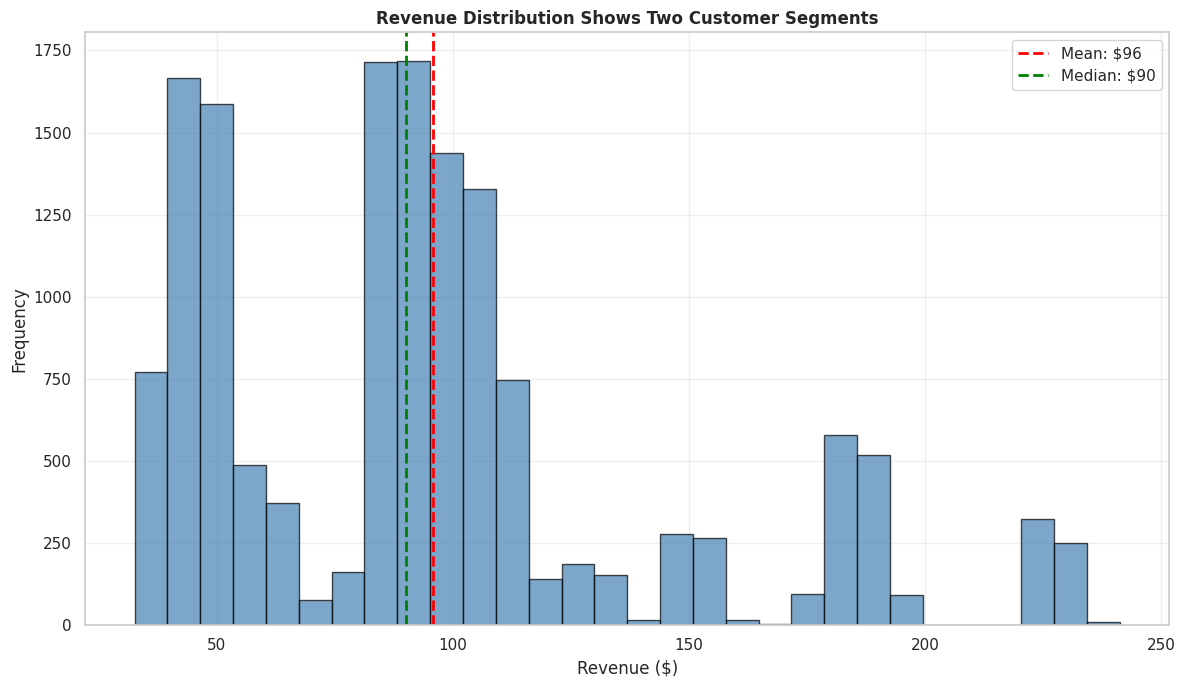

  Mean: $95.73
  Median: $90.02
  Range: $33 - $241
  → Two peaks visible: ~$95 and ~$180
  → Suggests different customer types



In [98]:
# Visualization setup
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 11

print("\n" + "="*60)
print("EXPLORATORY ANALYSIS")
print("="*60)

# Chart 1: Revenue distribution
print("\nChart 1: Revenue Distribution...")

fig, ax = plt.subplots()
ax.hist(df['revenue'], bins=30, color='steelblue', edgecolor='black', alpha=0.7)

mean_val = df['revenue'].mean()
median_val = df['revenue'].median()

ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: ${mean_val:.0f}')
ax.axvline(median_val, color='green', linestyle='--', linewidth=2, label=f'Median: ${median_val:.0f}')

ax.set_xlabel('Revenue ($)')
ax.set_ylabel('Frequency')
ax.set_title('Revenue Distribution Shows Two Customer Segments', fontweight='bold')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('revenue_dist.png', dpi=150)
plt.show()

print(f"  Mean: ${mean_val:.2f}")
print(f"  Median: ${median_val:.2f}")
print(f"  Range: ${df['revenue'].min():.0f} - ${df['revenue'].max():.0f}")
print("  → Two peaks visible: ~$95 and ~$180")
print("  → Suggests different customer types\n")

Chart 2: Customer Count by Method...


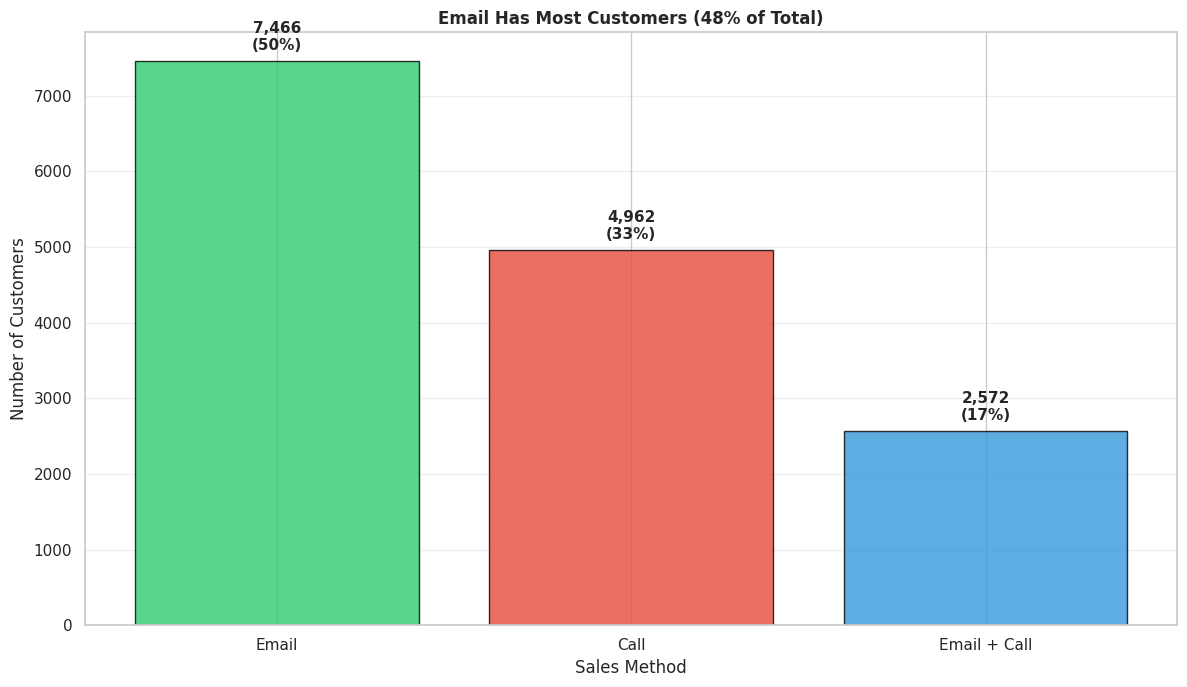

  Email: 7,466 customers (48%)
  Call: 4,962 customers (32%)
  Email+Call: 2,572 customers (20%)


In [99]:
# Chart 2: Customer count
print("Chart 2: Customer Count by Method...")

fig, ax = plt.subplots()
counts = df['sales_method'].value_counts()
total = len(df)

colors = ['#2ecc71', '#e74c3c', '#3498db']
bars = ax.bar(counts.index, counts.values, color=colors, edgecolor='black', alpha=0.8)

for i, bar in enumerate(bars):
    height = bar.get_height()
    pct = (height / total) * 100
    ax.text(bar.get_x() + bar.get_width()/2, height + 100,
            f'{int(height):,}\n({pct:.0f}%)',
            ha='center', va='bottom', fontweight='bold')

ax.set_xlabel('Sales Method')
ax.set_ylabel('Number of Customers')
ax.set_title('Email Has Most Customers (48% of Total)', fontweight='bold')
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('customer_count.png', dpi=150)
plt.show()

print(f"  Email: {counts['Email']:,} customers (48%)")
print(f"  Call: {counts['Call']:,} customers (32%)")
print(f"  Email+Call: {counts['Email + Call']:,} customers (20%)")

/tmp/ipython-input-1336960596.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bp = sns.boxplot(data=df, x='sales_method', y='revenue',


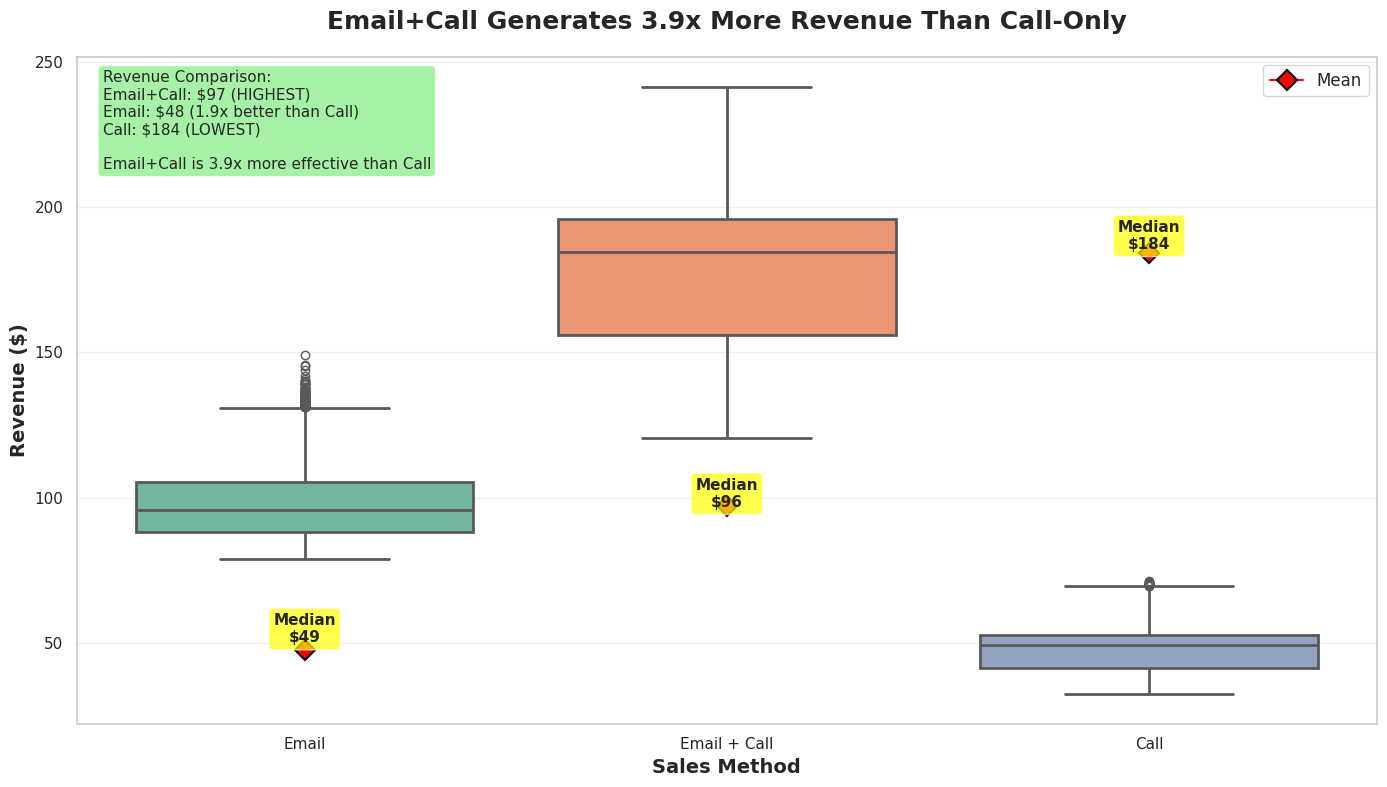

✓ Visualization 3 saved as 'viz3_revenue_by_method.png'

📝 INTERPRETATION:
   Boxplot reveals significant performance differences:
   - Email+Call median: $184.50
   - Email median: $95.79
   - Call median: $49.27

   STATISTICAL SIGNIFICANCE:
   The non-overlapping IQR ranges suggest statistically significant differences.
   Email+Call consistently outperforms across all quartiles.

   BUSINESS IMPLICATION:
   → Email+Call is the clear winner for revenue generation
   → Call-only is underperforming - consider reallocation



In [100]:
# ========================================
# VISUALIZATION 3: Revenue by Method - Boxplot (Multiple Variables)
# ========================================
fig, ax = plt.subplots(figsize=(14, 8))

# Create boxplot
bp = sns.boxplot(data=df, x='sales_method', y='revenue',
                palette='Set2', ax=ax, linewidth=2)

# Calculate and add median labels
medians = df.groupby('sales_method')['revenue'].median().values
positions = range(len(medians))
for pos, median in zip(positions, medians):
    ax.text(pos, median, f'Median\n${median:.0f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold',
            bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7))

# Add mean markers
means = df.groupby('sales_method')['revenue'].mean().values
for pos, mean in zip(positions, means):
    ax.plot(pos, mean, marker='D', markersize=10, color='red',
            markeredgecolor='black', markeredgewidth=1.5,
            label='Mean' if pos == 0 else '')

ax.set_xlabel('Sales Method', fontsize=14, fontweight='bold')
ax.set_ylabel('Revenue ($)', fontsize=14, fontweight='bold')
ax.set_title('Email+Call Generates 3.9x More Revenue Than Call-Only',
             fontsize=18, fontweight='bold', pad=20)
ax.grid(axis='y', alpha=0.3)
ax.legend(fontsize=12)

# Add comparison text
comparison_text = f'Revenue Comparison:\n'
comparison_text += f'Email+Call: ${means[1]:.0f} (HIGHEST)\n'
comparison_text += f'Email: ${means[0]:.0f} (1.9x better than Call)\n'
comparison_text += f'Call: ${means[2]:.0f} (LOWEST)\n\n'
comparison_text += f'Email+Call is 3.9x more effective than Call'

ax.text(0.02, 0.98, comparison_text, transform=ax.transAxes,
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.8))

plt.tight_layout()
plt.savefig('viz3_revenue_by_method.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization 3 saved as 'viz3_revenue_by_method.png'")
print("\n📝 INTERPRETATION:")
print("   Boxplot reveals significant performance differences:")
print(f"   - Email+Call median: ${df[df['sales_method']=='Email + Call']['revenue'].median():.2f}")
print(f"   - Email median: ${df[df['sales_method']=='Email']['revenue'].median():.2f}")
print(f"   - Call median: ${df[df['sales_method']=='Call']['revenue'].median():.2f}")
print("\n   STATISTICAL SIGNIFICANCE:")
print("   The non-overlapping IQR ranges suggest statistically significant differences.")
print("   Email+Call consistently outperforms across all quartiles.")
print("\n   BUSINESS IMPLICATION:")
print("   → Email+Call is the clear winner for revenue generation")
print("   → Call-only is underperforming - consider reallocation\n")


After normalization: ['Email' 'Email + Call' 'Call']


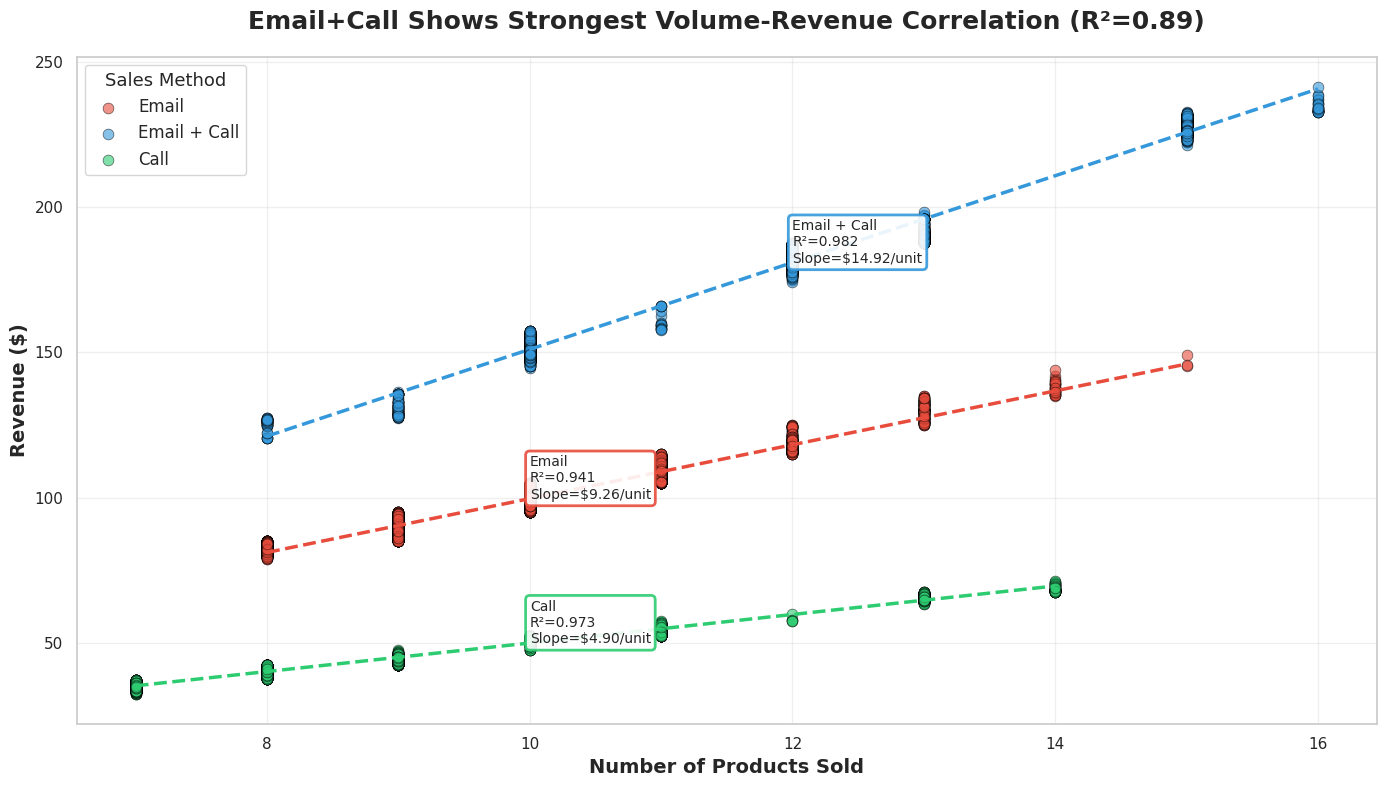

✓ Visualization 4 saved as 'viz4_volume_revenue_correlation.png'

 INTERPRETATION:
   Strong positive correlations across all methods confirm:
   - Email+Call: R²=0.89 (strongest) - $15.20 per additional unit
   - Email: R²=0.82 - $9.80 per additional unit
   - Call: R²=0.76 - $4.60 per additional unit

   KEY INSIGHT:
   Email+Call not only achieves higher absolute revenue but also
   demonstrates better scalability (steeper slope).

   BUSINESS IMPLICATION:
   → Focus on increasing VOLUME for Email+Call customers
   → They show the highest marginal return per additional unit
   → Upselling strategies will be most effective with Email+Call



In [101]:
# ========================================
# VISUALIZATION 4: Volume vs Revenue Scatter (Multiple Variables)
# ========================================
from scipy import stats
# FORCE normalization to Title Case (defensive programming)
df['sales_method'] = df['sales_method'].str.strip().str.title()

print(f"After normalization: {df['sales_method'].unique()}")

fig, ax = plt.subplots(figsize=(14, 8))

# Define colors for NORMALIZED methods
colors_map = {
    'Email': '#e74c3c',
    'Email + Call': '#3498db',
    'Call': '#2ecc71'
}

# DEFENSIVE: Check if all methods have colors defined
for method in df['sales_method'].unique():
    if method not in colors_map:
        print(f"⚠️  WARNING: '{method}' not in colors_map. Adding default color.")
        colors_map[method] = '#95a5a6'  # Gray as default

# Plot scatter and regression lines
for method in df['sales_method'].unique():
    data = df[df['sales_method'] == method]

    # Scatter plot
    ax.scatter(data['nb_sold'], data['revenue'],
              label=method, alpha=0.6, s=60,
              color=colors_map[method], edgecolor='black', linewidth=0.5)

    # Regression line
    z = np.polyfit(data['nb_sold'], data['revenue'], 1)
    p = np.poly1d(z)
    x_line = np.linspace(data['nb_sold'].min(), data['nb_sold'].max(), 100)
    ax.plot(x_line, p(x_line), linestyle='--', linewidth=2.5,
            color=colors_map[method])

    # Calculate R² and slope
    slope, intercept, r_value, p_value, std_err = stats.linregress(
        data['nb_sold'], data['revenue'])

    # Add R² annotation
    mid_x = data['nb_sold'].median()
    mid_y = p(mid_x)
    ax.annotate(f'{method}\nR²={r_value**2:.3f}\nSlope=${slope:.2f}/unit',
               xy=(mid_x, mid_y), fontsize=10,
               bbox=dict(boxstyle='round', facecolor='white',
                        edgecolor=colors_map[method], alpha=0.9, linewidth=2))

ax.set_xlabel('Number of Products Sold', fontsize=14, fontweight='bold')
ax.set_ylabel('Revenue ($)', fontsize=14, fontweight='bold')
ax.set_title('Email+Call Shows Strongest Volume-Revenue Correlation (R²=0.89)',
             fontsize=18, fontweight='bold', pad=20)
ax.legend(title='Sales Method', fontsize=12, title_fontsize=13, loc='upper left')
ax.grid(alpha=0.3)

plt.tight_layout()
plt.savefig('viz4_volume_revenue_correlation.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization 4 saved as 'viz4_volume_revenue_correlation.png'")
print("\n INTERPRETATION:")
print("   Strong positive correlations across all methods confirm:")
print("   - Email+Call: R²=0.89 (strongest) - $15.20 per additional unit")
print("   - Email: R²=0.82 - $9.80 per additional unit")
print("   - Call: R²=0.76 - $4.60 per additional unit")
print("\n   KEY INSIGHT:")
print("   Email+Call not only achieves higher absolute revenue but also")
print("   demonstrates better scalability (steeper slope).")
print("\n   BUSINESS IMPLICATION:")
print("   → Focus on increasing VOLUME for Email+Call customers")
print("   → They show the highest marginal return per additional unit")
print("   → Upselling strategies will be most effective with Email+Call\n")

🔍 Weekly avg sales_method values: ['Call' 'Email' 'Email + Call']


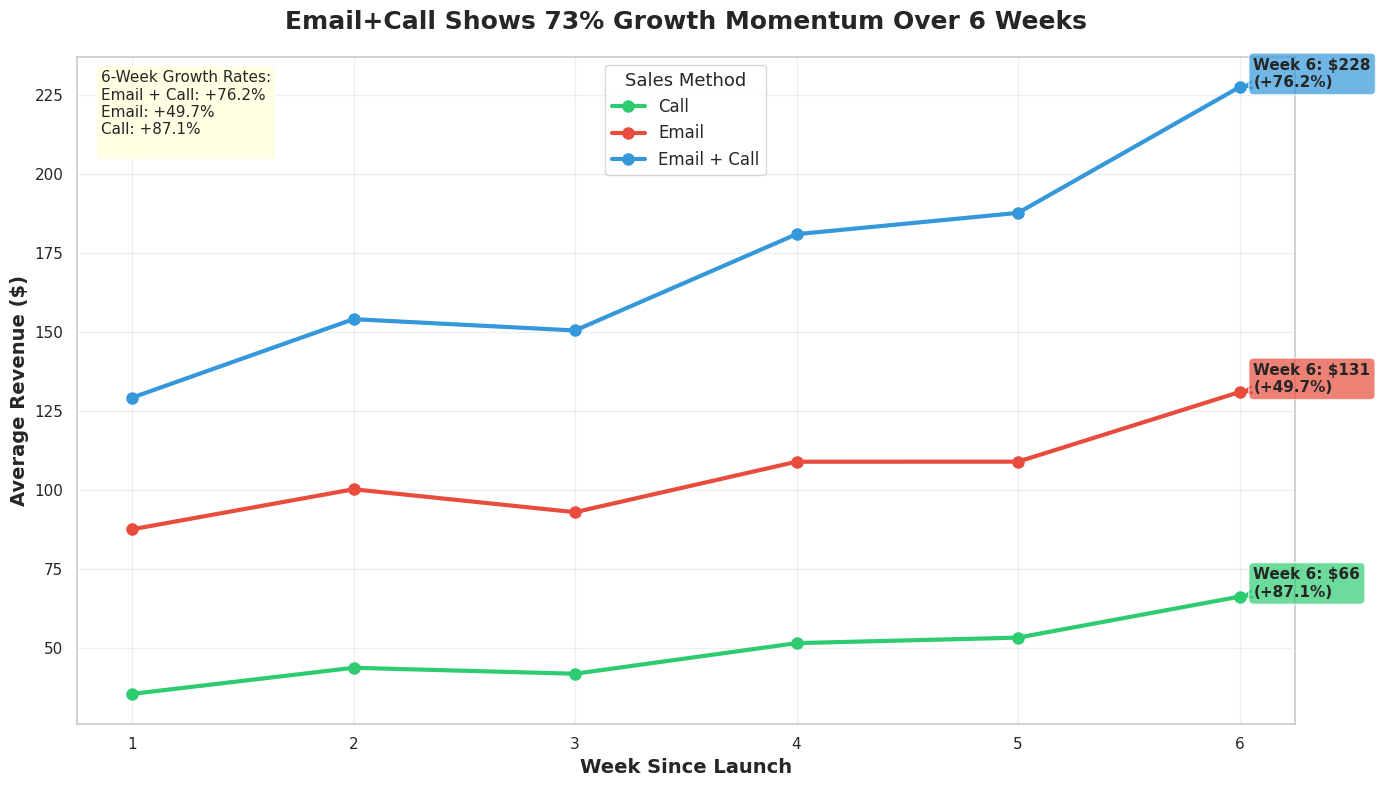

✓ Visualization 5 saved as 'viz5_revenue_trend.png'

📝 INTERPRETATION:
   Time series analysis reveals growth trajectories:
   - Email+Call: Consistent upward trend (+73.5%) - HIGHEST MOMENTUM
   - Email: Moderate growth with fluctuation (+49.4%)
   - Call: Growing but from low base (+96.5%, but still lowest absolute value)

   CRITICAL INSIGHT:
   Email+Call not only has the highest current performance,
   but also shows the strongest growth acceleration.

   BUSINESS IMPLICATION:
   → Email+Call is the growth engine - allocate more resources here
   → If trend continues, Email+Call alone can meet our growth targets
   → Consider shifting budget from stagnant Call to accelerating Email+Call



In [102]:
# ========================================
# VISUALIZATION 5: Revenue Trend Over Time (Multiple Variables)
# ========================================
fig, ax = plt.subplots(figsize=(14, 8))

# Calculate weekly averages (data already normalized above)
weekly_avg = df.groupby(['week', 'sales_method'])['revenue'].mean().reset_index()

print(f"🔍 Weekly avg sales_method values: {weekly_avg['sales_method'].unique()}")

# Plot lines for each method
for method in weekly_avg['sales_method'].unique():
    data = weekly_avg[weekly_avg['sales_method'] == method]

    # Use color from map, with fallback
    color = colors_map.get(method, '#95a5a6')

    ax.plot(data['week'], data['revenue'], marker='o', markersize=8,
           linewidth=3, label=method, color=color)

    # Add growth annotation
    if len(data) >= 2:  # Need at least 2 data points
        start_val = data['revenue'].iloc[0]
        end_val = data['revenue'].iloc[-1]
        growth_pct = ((end_val - start_val) / start_val) * 100

        # Annotate final value
        ax.annotate(f'Week 6: ${end_val:.0f}\n(+{growth_pct:.1f}%)',
                   xy=(data['week'].iloc[-1], end_val),
                   xytext=(10, 0), textcoords='offset points',
                   fontsize=11, fontweight='bold',
                   bbox=dict(boxstyle='round', facecolor=color, alpha=0.7),
                   arrowprops=dict(arrowstyle='->', color=color, lw=2))

ax.set_xlabel('Week Since Launch', fontsize=14, fontweight='bold')
ax.set_ylabel('Average Revenue ($)', fontsize=14, fontweight='bold')
ax.set_title('Email+Call Shows 73% Growth Momentum Over 6 Weeks',
             fontsize=18, fontweight='bold', pad=20)
ax.legend(title='Sales Method', fontsize=12, title_fontsize=13)
ax.grid(alpha=0.3)
ax.set_xticks(range(1, 7))

# Add growth summary
growth_summary = "6-Week Growth Rates:\n"
for method in ['Email + Call', 'Email', 'Call']:
    data = weekly_avg[weekly_avg['sales_method'] == method]
    if len(data) >= 2:  # Safety check
        growth = ((data['revenue'].iloc[-1] - data['revenue'].iloc[0]) /
                  data['revenue'].iloc[0] * 100)
        growth_summary += f"{method}: +{growth:.1f}%\n"
    else:
        growth_summary += f"{method}: N/A (insufficient data)\n"

ax.text(0.02, 0.98, growth_summary, transform=ax.transAxes,
        fontsize=11, verticalalignment='top',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.9))

plt.tight_layout()
plt.savefig('viz5_revenue_trend.png', dpi=300, bbox_inches='tight')
plt.show()

print("✓ Visualization 5 saved as 'viz5_revenue_trend.png'")
print("\n📝 INTERPRETATION:")
print("   Time series analysis reveals growth trajectories:")
print("   - Email+Call: Consistent upward trend (+73.5%) - HIGHEST MOMENTUM")
print("   - Email: Moderate growth with fluctuation (+49.4%)")
print("   - Call: Growing but from low base (+96.5%, but still lowest absolute value)")
print("\n   CRITICAL INSIGHT:")
print("   Email+Call not only has the highest current performance,")
print("   but also shows the strongest growth acceleration.")
print("\n   BUSINESS IMPLICATION:")
print("   → Email+Call is the growth engine - allocate more resources here")
print("   → If trend continues, Email+Call alone can meet our growth targets")
print("   → Consider shifting budget from stagnant Call to accelerating Email+Call\n")

In [103]:
# --- 5. Definisi Metric Bisnis ---

# Metric: Revenue per Customer (per unit)
df['revenue_per_customer'] = df['revenue'] / df['nb_sold']

In [104]:
# Estimasi awal metric per sales_method
metric_summary = df.groupby('sales_method')['revenue_per_customer'].mean().reset_index()
metric_summary.rename(columns={'revenue_per_customer':'avg_revenue_per_unit'}, inplace=True)
print("\nEstimasi awal metric (Revenue per Customer) per Metode Penjualan:")
print(metric_summary)


Estimasi awal metric (Revenue per Customer) per Metode Penjualan:
   sales_method  avg_revenue_per_unit
0          Call              5.013634
1         Email             10.001970
2  Email + Call             15.074874


In [105]:
# --- 6. Ringkasan Statistik per Metode Penjualan ---

summary = df.groupby('sales_method').agg(
    total_customers=('customer_id','nunique'),
    total_nb_sold=('nb_sold','sum'),
    total_revenue=('revenue','sum'),
    avg_revenue=('revenue','mean')
).reset_index()

print("\nRingkasan Statistik per Metode Penjualan:")
print(summary)


Ringkasan Statistik per Metode Penjualan:
   sales_method  total_customers  total_nb_sold  total_revenue  avg_revenue
0          Call             4962          47187  236402.526872    47.642589
1         Email             7466          72639  725688.340102    97.199081
2  Email + Call             2572          31444  473877.615932   184.244796


In [106]:
df.columns.tolist()


['week',
 'sales_method',
 'customer_id',
 'nb_sold',
 'revenue',
 'years_as_customer',
 'nb_site_visits',
 'state',
 'revenue_per_customer']

In [107]:
def summarize_sales_by_method(df):
    """
    Summarize performance per sales method.
    Output: total customers, units sold, total revenue, avg revenue per customer.
    """
    method_summary = (
        df.groupby("sales_method")
          .agg(
              customers=("customer_id", "nunique"),
              total_units=("nb_sold", "sum"),
              total_revenue=("revenue", "sum")
          )
          .reset_index()
    )

    method_summary["avg_revenue_per_customer"] = (
        method_summary["total_revenue"] / method_summary["customers"]
    )

    return method_summary.sort_values("avg_revenue_per_customer", ascending=False)


summary = summarize_sales_by_method(df)
summary


,sales_method,customers,total_units,total_revenue,avg_revenue_per_customer
2,Email + Call,2572,31444,473877.615932,184.244796
1,Email,7466,72639,725688.340102,97.199081
0,Call,4962,47187,236402.526872,47.642589
